<a href="https://colab.research.google.com/github/tiyu0203/fml/blob/master/FML_proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Frequentist Machine Learning**

**Assignment 1**

**Tiffany Yu**

Replicate the analysis from chapter 3 of this dataset. Divide your data into roughly 80% train, 10% validation, 10% test. You must keep this split for all 3 parts of this assignment in order to compare the methods fairly. Replicate the textbooks analysis of this dataset. by doing the following

In [ ]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import linear_model
from tabulate import tabulate 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


class Classifier:
    def __init__(self, dataset, X, y):

      #split into train, validation, test datasets
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
      self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, random_state=42, shuffle=True)

      #add a column of ones for the intercept
      self.X_train = np.concatenate((np.ones((self.X_train.shape[0], 1)),self.X_train), axis = 1)
      self.X_test = np.concatenate((np.ones((self.X_test.shape[0], 1)),self.X_test), axis = 1)
      self.X_val = np.concatenate((np.ones((self.X_val.shape[0], 1)),self.X_val), axis = 1)
      
      #standardize features
      self.X_train = preprocessing.normalize(self.X_train)
      self.X_test = preprocessing.normalize(self.X_test)
      self.X_val = preprocessing.normalize(self.X_val)

    def linearRegression(self):
      #  Using eq 3.6 to find the betas
      # eq 3.6 --> β̂ = (X T X) −1 X T y
      beta_hat = np.linalg.inv(self.X_train.T.dot(self.X_train)).dot(self.X_train.T).dot(self.y_train)

      #ŷ = X β̂
      y_hat = self.X_test.dot(beta_hat)
      y_hat_train = self.X_train.dot(beta_hat)

      # mean squared error on training dataset
      train_MSE = np.mean(np.square(np.subtract(self.y_train,y_hat_train)))
      print("Linear Regression MSE on training set:", train_MSE)
      base_train_MSE = np.mean(np.subtract(np.mean(self.y_train), self.y_val))
      #since the MSE calculated is much less than the baseline
      #we want the MSE to be lower than the baseline

      # mean squared error on the test dataset
      test_MSE = np.mean(np.square(np.subtract(self.y_test,y_hat)))
      print("Linear Regression MSE on test set:", test_MSE)
      print("Baseline MSE :", base_train_MSE)
      #since the MSE calculated is much less than the baseline
      #we want the MSE to be lower than the baseline

    def tableOne(self, dataset):
      #correlation table for table 3.1

      #get the coefficient names for the columns
      corr_names = list(dataset.columns.values[:-1])
      #calculate the correlation coefficients
      coef_corr = dataset.corr()

      #removes the extraneous information and only take the lower triangle portion of the values
      coef_corr = np.tril(coef_corr, k = -1) #only keeps the lower triangle of values under the diagonal of ones 
      #gets rid of the extra columns and rows (in order to get the values needed for the table)
      coef_corr = np.delete(coef_corr, (0), axis=0)
      coef_corr = np.delete(coef_corr, (8), axis=1)
      coef_corr = np.delete(coef_corr, (7), axis=0)
      coef_corr = np.delete(coef_corr, (7), axis=1)

      #place all the values into the table
      corr_table = [] 
      for x in range(len(corr_names)-1):
        rows = []
        for y in range(len(corr_names)-1):
          #since the values are in a triangle position, the coordinates of each row will be: [0,0]; [1,0] [1,1]
          #to iterate through them all and only take the coordinates with values, that is when y <-x 
          if y <= x:
            #takes the value at the position and appends it to the row to get all the values in the row
            rows.append(coef_corr[x,y])
        #rounds the values 
        rows = [str(round(row,3)) for row in rows]
        #places the names of the rows in before the beginning of the row so it can be used as the coefficient name
        rows.insert(0,corr_names[x+1])
        #inserts the rows into the table
        corr_table.append(rows)

      #have to input this to fix the headers to have the proper names (otherwise it won't look like the textbook table and the headers would be off by one)
      corr_names.insert(0,'Coefficients')
      #create and print out the table
      corr = tabulate(corr_table[0:], headers = (corr_names))
      #the title of the table
      print('Table 1: Correlations of predictors in the dataset')
      print(corr)

    def tableTwo(self, dataset):

      #creating table 3.2
      #calculate all the variables in order to calculate the z-score and standard error
      #coefficient = β̂ j
      #calculate what p and N are to be used to calculate sigma
      p = self.X_train.shape[1]
      N = len(self.X_train)

      #v j is the jth diagonal element of (X T X) −1
      v = np.diagonal(np.linalg.inv(np.matmul(self.X_train.T, self.X_train)))

      #variance from eq 3.8
      #σ̂ = (1/ (N − p − 1)) *sum(from i=1 to N)(y i − ŷ i ) 2
      #sigma = np.sqrt(np.sum(y_hat - y))
      beta_hat = np.linalg.inv(self.X_train.T.dot(self.X_train)).dot(self.X_train.T).dot(self.y_train)
      y_hat_train = self.X_train.dot(beta_hat)
      sigma = np.sqrt(np.sum((np.subtract(self.y_train, y_hat_train)**2))/(N - p - 1))

      #standard error = sigma*standard error
      standard_error = np.sqrt(v)*sigma

      #The Z score is the coefficient divided by its standard error (3.12).
      #z-score = β̂ j/ (σ̂* sqrt(v))
      z_score = beta_hat/standard_error

      #get the coefficient names for the rows
      term = list(dataset.columns.values[:-1])

      #insert intercept to have the correct headers
      term.insert(0, 'intercept')

      #create the table 3.2 and format all the data
      table_three = []
      for x in range(len(term)):
        #to create each row, it is the term, the beta hat, standard error and zscore of the term
        row = list([term[x],
          beta_hat[x],
          standard_error[x],
          z_score[x]])
        #each row is inserted in the tabl
        table_three.append(row)
      #the header of the table
      table_header = ['Term', 'Coefficeint', 'Std. Error', 'Z Score']
      #creates the table
      table_three_two = tabulate(table_three, headers = table_header)
      #the title of the table
      print('Table 2: Linear model fit to the dataset.')
      print(table_three_two)

    def ridgeRegression(self, dataset):
      #create an identity matrix the size of the x training set
      identity = np.identity(self.X_train.shape[1])
      #get all the categories
      categories = list(dataset.columns.values[:-1])

      #initialize it bestMSE to some large number for comparison
      #we chose some arbitrarily high number because the first time we calculate an MSE we have nothing to compare it to so we want to make sure that whatever the MSE is, is chosen
      #the MSE shoudl definitely be lower than this arbitrarily big number and if not, then something is wrong with the calculations
      bestMSE = float("inf")

      #create a bunch of lambdas in order to iterate through them
      lams = np.logspace(-15, 15, 1000)

      for lam in lams:
        #using eq 3.44 to find the betas
        #β̂ ridge = (X T X + λI) −1 X T y
        beta_ridge_hat = np.linalg.inv((self.X_train.T.dot(self.X_train) + lam*(identity))).dot(self.X_train.T.dot(self.y_train))
        #we use the validation set in order to do cross-validationg
        #ŷ = X β̂
        r_y_hat = self.X_val.dot(beta_ridge_hat)
        #Select the optimal value of Lambda by cross-validation using the validation dataset.
        r_MSE = np.mean(np.square(np.subtract(self.y_val,r_y_hat)))
        #we are looking for the smallest MSE, which would be the best MSE so for each one we compare with the previous to make sure it's the smallest
        if (r_MSE < bestMSE):
          bestLambda = lam
          bestMSE = r_MSE
      print("Lambda selected by cross-validation:", bestLambda)
      print("MSE from the lambda selected by cross-validation:", bestMSE)
      #we selected the most optimal lambda by iterating through a bunch of lambdas and calculating the beta_hat and y_hat and MSE based on the validation set
      #the smaller the MSE the better, so whichever MSE is the smallest, we know at that lambda it is the most optimal

      self.bestLambda = bestLambda
      #calculate the MSE from the training set
      beta_ridge_hat = np.linalg.inv((self.X_train.T.dot(self.X_train) + bestLambda*(identity))).dot(self.X_train.T.dot(self.y_train))
      r_y_hat = self.X_train.dot(beta_ridge_hat)
      r_MSE = np.mean(np.square(np.subtract(self.y_train,r_y_hat)))
      print("Ridge Regression MSE on training set:", r_MSE)
      #the baseline MSE from the training set is the mean of the y_train
      #since the MSE calculated is much less than the baseline
      #we want the MSE to be lower than the baseline MSE

      #report the mean squared error on the test dataset, using the best lambda you found on the validation set. 
      #DO NOT USE THE TEST DATASET TO CHOOSE LAMBDA.
      beta_ridge_hat = np.linalg.inv((self.X_test.T.dot(self.X_test) + bestLambda*(identity))).dot(self.X_test.T.dot(self.y_test))
      r_y_hat = self.X_test.dot(beta_ridge_hat)
      r_MSE = np.mean(np.square(np.subtract(self.y_test,r_y_hat)))
      base_train_MSE = np.mean(np.subtract(np.mean(self.y_train), self.y_val))
      print("Ridge Regression MSE on test set:", r_MSE)
      print("Baseline MSE :", base_train_MSE)
      #the baseline MSE from the test set is the mean of the y_test
      #since the MSE calculated is much less than the baseline
      #we want the MSE to be lower than the baseline MSE

    def plotRidge(self):
      #create an identity matrix the size of the x training set
      identity = np.identity(self.X_train.shape[1])
      #get all the categories
      categories = list(dataset.columns.values[:-1])
      #Plot a ridge plot similar to figure 3.8, but you can just sweep the lambda parameter (you don't have to scale it to degrees of freedom).
      X = []
      Y = []

      lams = np.logspace(-15, 15, 1000)

      #for each lambda, a beta is calculated
      for lam in lams:
        beta_ridge_hat = np.linalg.inv((self.X_train.T.dot(self.X_train) + lam*(identity))).dot(self.X_train.T).dot(self.y_train)
        #df(λ)= tr[X(X T X + λI) −1 X T ] eq 3.50
        #DOF = np.matrix(r_x_train.dot(np.linalg.inv((r_x_train.T.dot(r_x_train) + lam*(identity))).dot(r_x_train.T)))
        #the x axis is the lambdas
        X.append(lam)
        #the y axis is the betas
        Y.append(beta_ridge_hat)
      plt.figure
      #plots the x axis in log format
      plt.xscale("log")

      #place the labels
      for i in range(0,8):
        plt.plot(X, list(map(list, zip(*Y)))[i], label = categories[i] )

      #plots the figure
      plt.title("Profiles of ridge coefficients")
      plt.xlabel('λ')
      plt.ylabel('Coefficients') 
      plt.legend()
      ymin, ymax = plt.ylim()
      plt.vlines(self.bestLambda, ymin, ymax, linestyle='dashed', colors='red')
      plt.show() 

    def lassoRegression(self):
      #initialize it bestMSE to some large number for comparison
      #want to reinitialize it to an arbitrarily big number
      #we chose some arbitrarily high number because the first time we calculate an MSE we have nothing to compare it to so we want to make sure that whatever the MSE is, is chosen
      #the MSE shoudl definitely be lower than this arbitrarily big number and if not, then something is wrong with the calculations
      bestMSE = float("inf")

      lams = np.logspace(-15, 15, 1000)

      #Select the optimal value of lambda as in part b
      for lam in lams:
        #Linear Model trained with L1 prior as regularizer (aka the Lasso)
        clf = linear_model.Lasso(alpha=lam)
        #fit(X, y[, sample_weight, check_input]) Fit model with coordinate descent.
        clf.fit(self.X_train, self.y_train)
        #Predict using the linear model.
        l_y_hat = clf.predict(self.X_val)
        #calculates the MSE 
        l_MSE = np.mean(np.square(np.subtract(self.y_val,l_y_hat)))
        #we are looking for the smallest MSE, which would be the best MSE so for each one we compare with the previous to make sure it's the smallest
        if (l_MSE < bestMSE):
          bestLambda = lam
          bestMSE = l_MSE
      print("Lambda selected by cross-validation:", bestLambda)
      print("Lasso Regression MSE on validation set:", bestMSE)
      #we selected the most optimal lambda by iterating through a bunch of lambdas and calculating the beta_hat and y_hat and MSE based on the validation set
      #the smaller the MSE the better, so whichever MSE is the smallest, we know at that lambda it is the most optimal

      clf = linear_model.Lasso(alpha=bestLambda)

      #since we used linear_model.Lasso to calculate the model, The algorithm used to fit the model is coordinate descent.
      #Fit model with coordinate descent.
      #fit(X, y[, sample_weight, check_input]) 
      clf.fit(self.X_train, self.y_train)

      #Predict using the linear model.
      #given a trained model, predict the label of a new set of data
      l_y_hat = clf.predict(self.X_train)

      #calculate the MSE based on the training set
      l_train_MSE = np.mean(np.square(np.subtract(self.y_train,l_y_hat)))
      print("Lasso Regression MSE on training set:", l_train_MSE)
      #the baseline MSE from the training set is the mean of the y_train
      #since the MSE calculated is much less than the baseline
      #we want the MSE to be less than the baseline

      #calculate the MSE based on the test set
      clf = linear_model.Lasso(alpha=bestLambda)
      clf.fit(self.X_train, self.y_train)
      l_y_hat = clf.predict(self.X_test)
      l_test_MSE = np.mean(np.square(np.subtract(self.y_test,l_y_hat)))
      base_train_MSE = np.mean(np.subtract(np.mean(self.y_train), self.y_val))
      print("Lasso Regression MSE on test set:", l_test_MSE)
      print("Baseline MSE :", base_train_MSE)
      #the baseline MSE from the test set is the mean of the y_test
      #since the MSE calculated is much less than the baseline
      #we want the MSE to be less than the baseline

    def plotLasso(self):
      categories = list(dataset.columns.values[:-1])
      # Display a Lasso plot (there are built in functions for Lasso plot in sci-kit/MATLAB). 
      #found on https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
      _, _, coefs = linear_model.lars_path(self.X_train, self.y_train, method='lasso', verbose=True)

      #normalize the coefficients so they aren't so big 
      #idk Prof Keene said to do so
      coefs = preprocessing.normalize(coefs)
      xx = np.sum(np.abs(coefs.T), axis=1)
      xx /= xx[-1]
      plt.plot(xx, coefs.T)
      #print the plotted figure
      ymin, ymax = plt.ylim()
      #plt.vlines(xx, ymin, ymax, linestyle='dashed')
      plt.xlabel('|coef| / max|coef|')
      plt.ylabel('Coefficients')
      plt.title('LASSO Path')
      plt.legend(categories, bbox_to_anchor=(1.05, 1))
      plt.axis('tight')
      plt.show()

class Stretch:
    def __init__(self, dataset, X, y):

      #split into train, validation, test datasets
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
      self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25, random_state=42, shuffle=True)

    def nonLinear(self):
      beta_hat = np.linalg.inv(self.X_train.T.dot(self.X_train)).dot(self.X_train.T).dot(self.y_train)
      y_hat = self.X_test.dot(beta_hat)
      y_hat_train = self.X_train.dot(beta_hat)

      # mean squared error on training dataset
      train_MSE = np.mean(np.square(np.subtract(self.y_train,y_hat_train)))
      print("Non Linear Regression2111 MSE on training set:", train_MSE)

      Classifier(dataset, X, y).lassoRegression()
      Classifier(dataset,X,y).plotLasso()

In [ ]:
#import prostrate_data.data
dataset = pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data', delimiter='\t', usecols=list(np.arange(0,10)), index_col=0)
X = dataset.iloc[:,:8]
y = dataset.iloc[:,8]

---
## Linear Regression with no regularization
a) Plain old linear regression, with no regularization. You must code this one by hand (i.e use equation 3.6 to find the betas).  Report the mean squared error on the test dataset. Replicate tables 3.1 and 3.2. You will not need the validation set for this part of the assigment.

In [ ]:
#Create classifier
classifier = Classifier(dataset, X,y)

In [ ]:
#linear regression
classifier.linearRegression()

Linear Regression MSE on training set: 0.42240251935788553
Linear Regression MSE on test set: 0.37056313782889766
Baseline MSE : 0.11852481692982542


In [ ]:
#Replicate tables 3.1
classifier.tableOne(dataset)


Table 1: Correlations of predictors in the dataset
Coefficients      lcavol    lweight    age    lbph    svi    lcp    gleason
--------------  --------  ---------  -----  ------  -----  -----  ---------
lweight            0.281
age                0.225      0.348
lbph               0.027      0.442  0.35
svi                0.539      0.155  0.118  -0.086
lcp                0.675      0.165  0.128  -0.007  0.673
gleason            0.432      0.057  0.269   0.078  0.32   0.515
pgg45              0.434      0.107  0.276   0.078  0.458  0.632      0.752


In [ ]:
#replicate table 3.2
classifier.tableTwo(dataset)

Table 2: Linear model fit to the dataset.
Term         Coefficeint    Std. Error    Z Score
---------  -------------  ------------  ---------
intercept    -166.762       131.036     -1.27265
lcavol         32.4617        6.61557    4.90687
lweight        42.6623       17.3057     2.46522
age             0.779367      0.903479   0.862629
lbph            2.37873       5.33906    0.445533
svi            62.7548       22.9838     2.73039
lcp            -4.90036       7.31243   -0.670141
gleason         8.67021      16.956      0.511337
pgg45           1.45449       0.48574    2.99438


---
## Ridge Regression
b) Ridge regression. You must also code this one by hand(eq 3.44 to find the betas). Select the optimal value of Lambda by cross-validation using the validation dataset. Report the mean squared error on the test dataset, using the best lambda you found on the validation set. DO NOT USE THE TEST DATASET TO CHOOSE LAMBDA. Plot a ridge plot similar to figure 3.8, but you can just sweep the lambda parameter (you don't have to scale it to degrees of freedom).

In [ ]:
#ridge regression
classifier.ridgeRegression(dataset)

Lambda selected by cross-validation: 0.0001955650715865947
MSE from the lambda selected by cross-validation: 0.5263213740335451
Ridge Regression MSE on training set: 0.4355262866359816
Ridge Regression MSE on test set: 0.277310583231502
Baseline MSE : 0.11852481692982542


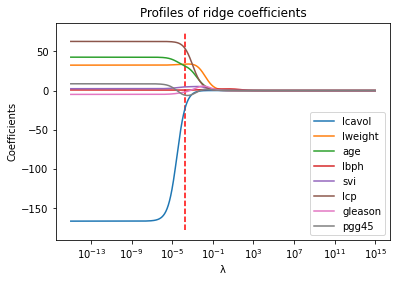

In [ ]:
#Plot a ridge plot similar to figure 3.8
classifier.plotRidge()

---
## Lasso Regression
c) Lasso regression: Use  the built in packages in sci-kit learn or MATLAB to do a Lasso regression. Select the optimal value of lambda as in part b) and also display a Lasso plot similar to figure 3.10, but again you can just sweep the lambda parameter. 

In [ ]:
#lasso regression
classifier.lassoRegression()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0562471743068276, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.845313851378826, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6359414481340853, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2

Lambda selected by cross-validation: 7.42798248256491e-05
Lasso Regression MSE on validation set: 0.5254528576025332
Lasso Regression MSE on training set: 0.4356019989714543
Lasso Regression MSE on test set: 0.41691129946360805
Baseline MSE : 0.11852481692982542


.

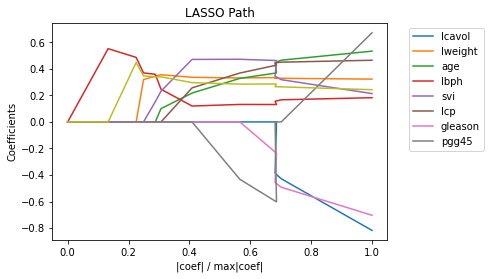

In [ ]:
#display a Lasso plot similar to figure 3.10
classifier.plotLasso()

The feature that was chosen by the Lasso model was lbph. Lbph stands for log of benign prostatic hyperplasia.
Since the feature is the first to emerge from the lasso model, that means it is the amount of benign prostatic hyperplasia is the strongest indicator of if someone has prostate cancer.
The yellow line appears second, however looking at the legend, the yellow line isn't one of the features and could be the intercepts 
Comparing the MSEs, Lasso is the least, then Ridge, then Linear. However, some of the values were close together since they were all around the same range. 

---
## Stretch goals

Stretch goal (2 points): Add nonlinear and interaction terms to your dataset and try to improve the performance. Are you able to do so? 

Non Linear Regression2111 MSE on training set: 5.253542005084818e+29


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.5520669279938, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.552066928110783, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.552066928236142, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10

Lambda selected by cross-validation: 2.63281546564802e-05
Lasso Regression MSE on validation set: 0.575389004901065
Lasso Regression MSE on training set: 0.5009178795727858
Lasso Regression MSE on test set: 0.8002088189431733
Baseline MSE : 0.11852481692982542
.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3713489566321968, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3713489566321968, tolerance: 0.007684741936593351
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=2.066e-05, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regr

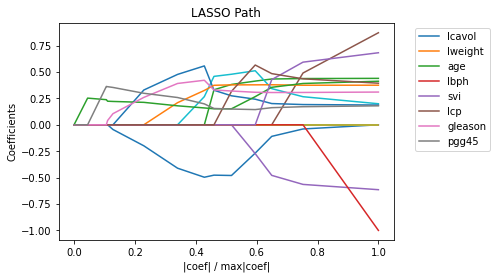

In [ ]:
#Includes the original features in addition to each feature being squared.
features = dataset.drop(columns='lpsa').columns
X = np.array(dataset[features])
X = np.append(X, X**2, axis=1)

X = np.hstack((np.ones((len(((X *2) / np.std(X))), 1)), ((X *2) / np.std(X))))

stretch = Stretch(dataset, X, y)

stretch.nonLinear()

Using non linear regression where each feauture is squared, we see that for all MSE values, the model produced worse results which means that it is a bad model. The features, chosen using lasso regresion on the non linear regression model, that appeared first were age and lcp, which were much different than the ones chosen before. Since the MSE's didn't improve, using a non linear regression doesn't mean that there will be a performance improvment. 

---
## Forest Fire Dataset
Next, download a dataset suitable for linear regression from UCI or another repository. For now, this should be a dataset that only has numerical features, with no missing values. Repeat the analysis above on this dataset.

Which features did the Lasso select for you to include in your model? Do these features make sense?
Compute the MSE on the training dataset and the test dataset for all methods and comment on the results.  Compare this MSE to a baseline MSE.

In [ ]:
#Selected Dataset: http://archive.ics.uci.edu/ml/datasets/Forest+Fires
#Dataset Description: https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.names
#The dataset shows a bunch of features that may factor into the amount of forest fires that occur
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')
# removed categorical feautures
dataset = dataset.drop(columns = {'month', 'day'})

#seperates the training, testing, and validation into x and y
#the 0-9 columns are the x data
#iloc is Purely integer-location based indexing for selection by position.
#the y is the rain column, but according to the description, we should model it with the logs 
#added one because otherwise the results would be infinite
# (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform). 

X = dataset.iloc[:,:10]
y = np.log(dataset.iloc[:, 10]+2)


---
## Linear Regression with no regularization for forest Fire Dataset
a) Plain old linear regression, with no regularization. You must code this one by hand (i.e use equation 3.6 to find the betas). Report the mean squared error on the test dataset. Replicate tables 3.1 and 3.2. You will not need the validation set for this part of the assigment.

In [ ]:
#classifier
classifier = Classifier(dataset, X, y)

In [ ]:
#linear regression
classifier.linearRegression()

Linear Regression MSE on training set: 1.2734044026609952
Linear Regression MSE on test set: 1.6084825098472324
Baseline MSE : 0.08741119910339637


In [ ]:
#Replicate tables 3.1
classifier.tableOne(dataset)

Table 1: Correlations of predictors in the dataset
Coefficients         X       Y    FFMC    DMC      DC     ISI    temp      RH    wind
--------------  ------  ------  ------  -----  ------  ------  ------  ------  ------
Y                0.54
FFMC            -0.021  -0.046
DMC             -0.048   0.008   0.383
DC              -0.086  -0.101   0.331  0.682
ISI              0.006  -0.024   0.532  0.305   0.229
temp            -0.051  -0.024   0.432  0.47    0.496   0.394
RH               0.085   0.062  -0.301  0.074  -0.039  -0.133  -0.527
wind             0.065   0.033   0.057  0.075   0.036   0.068   0.069   0
rain             0.063   0.045   0.04   0.073   0.049   0.008   0.098  -0.007       0


In [ ]:
#replicate table 3.2
classifier.tableTwo(dataset)

Table 2: Linear model fit to the dataset.
Term         Coefficeint    Std. Error    Z Score
---------  -------------  ------------  ---------
intercept    -134.746       324.959     -0.414656
X              22.7834       11.4269     1.99384
Y              10.4313       19.9048     0.524061
FFMC            1.01119       3.17732    0.318251
DMC             1.19783       0.911537   1.31408
DC              1.42542       0.183377   7.7732
ISI            -3.97408       7.54865   -0.526462
temp           -5.0792        6.01568   -0.844327
RH              0.179792      1.5066     0.119336
wind            4.39909      10.4188     0.422225
rain        -1092.49        702.008     -1.55623


---
## Ridge regression for forest fire dataset

b) Ridge regression. You must also code this one by hand(eq 3.44 to find the betas). Select the optimal value of Lambda by cross-validation using the validation dataset. Report the mean squared error on the test dataset, using the best lambda you found on the validation set. DO NOT USE THE TEST DATASET TO CHOOSE LAMBDA. Plot a ridge plot similar to figure 3.8, but you can just sweep the lambda parameter (you don't have to scale it to degrees of freedom).



In [ ]:
#ridge regression
classifier.ridgeRegression(dataset)

Lambda selected by cross-validation: 15.352750287804275
MSE from the lambda selected by cross-validation: 1.074490198145225
Ridge Regression MSE on training set: 1.33018519532696
Ridge Regression MSE on test set: 1.5798580459402705
Baseline MSE : 0.08741119910339637


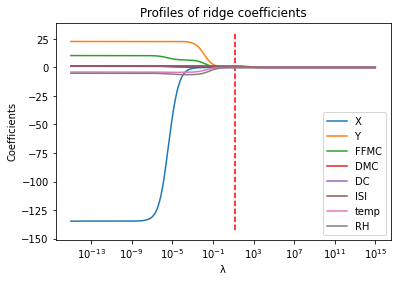

In [ ]:
#plot ridge regression
classifier.plotRidge()

---
## Lasso regression for forest fire dataset

c) Lasso regression: Use the built in packages in sci-kit learn or MATLAB to do a Lasso regression. Select the optimal value of lambda as in part b) and also display a Lasso plot similar to figure 3.10, but again you can just sweep the lambda parameter. 

In [ ]:
#lasso regression
classifier.lassoRegression()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.82182113565685, tolerance: 0.04098554259644342
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.82182087332384, tolerance: 0.04098554259644342
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.8218205922097, tolerance: 0.04098554259644342
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194.

Lambda selected by cross-validation: 0.026510836019085417
Lasso Regression MSE on validation set: 1.0686720903874003
Lasso Regression MSE on training set: 1.3263929642861978
Lasso Regression MSE on test set: 1.5204980782592463
Baseline MSE : 0.08741119910339637


.

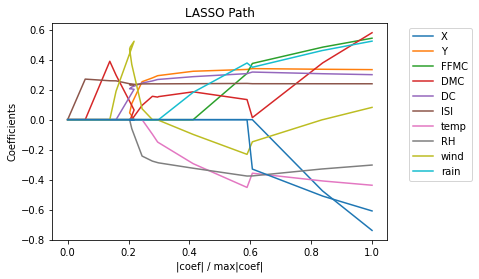

In [ ]:
#plot lasso regression
classifier.plotLasso()

The feature that was chosen by the Lasso model was ISI. ISI is the index from the FWI system. FWI is the forest fire weather index, which is the canadian system for rating fire danger
Since the feature is the first to emerge from the lasso model, that means it is the higher the number of the ISI is, the higher chance of there being a forest fire
This makes sense because extreme weathers such as heat and very dry air would be perfect for a fire to grow if accidentally started
After rerunning the code, the feature rain emerged first. This meant the amount of rain correlated to if there was a forest fire. 
This makes sense because the more likely there is rain, there is less of a chance with of a forest fire
The MSE values were higher for Lasso, lower for Ridge and much lower for Linear.  